In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image, Audio, clear_output

import geopandas

import pickle

import zipfile

import os

import re
from textblob import TextBlob

from scipy import sparse

import time

from notify_run import Notify

from ast import literal_eval as make_tuple

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster

from zipfile import ZipFile

import imageio

import shutil

import networkx as nx
from networkx.algorithms import community
import community as cm

from tqdm import tnrange, tqdm_notebook, tqdm

import dask.dataframe as dd

import collections

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

torch.cuda.get_device_name(0)

GPU = True
device_idx = 1
if GPU:
    device = torch.device("cuda:" + str(device_idx - 1) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

print(device)

cuda:0


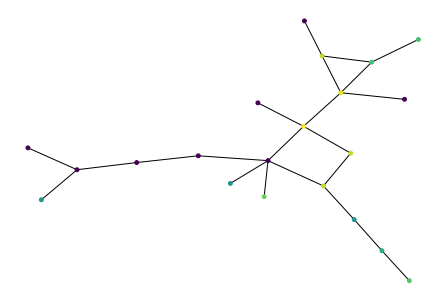

In [2]:
network = nx.read_graphml("runs/graphs/m5.graphml")

attrs = [nx.get_node_attributes(network, 'apt_markakis')[i] for i in network.nodes]

nx.draw_kamada_kawai(network, node_size=15, node_color=attrs)

# plt.show()

In [3]:
class StaticEncoder(nn.Module):
    def __init__(self, hidden_size, input_dim, mid_layer, corruption):
        super(StaticEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, mid_layer)
        self.linear2 = nn.Linear(mid_layer, hidden_size)
        
        self.linear3 = nn.Linear(hidden_size, mid_layer)
        self.linear4 = nn.Linear(mid_layer, input_dim)
        
        self.corrupt = corruption
        
        self.activ = nn.LeakyReLU()
        
    def encode(self, x):
        noise = torch.rand(x.shape)
        x[noise < self.corrupt] = 0
        
        x = self.linear1(x)
        x = self.activ(x)
        x = self.linear2(x)
        
        return x 
    
    def decode(self, z):
        
        z = self.linear3(z)
        z = self.activ(z)
        z = self.linear4(z)
        
        return z

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        
        return recon, z

In [4]:
class EdgeData(Dataset):
    def __init__(self, edges, data):
        self.edges = edges
        self.d = data
        
    def __getitem__(self, index):
        pairs = self.edges[index]
        v1 = index
        v2 = np.random.choice(pairs)
                        
        return self.d[v1], v1, self.d[v2], v2

    def __len__(self):
        return len(self.d)    


In [5]:
adj_list = [(int(n), [int(x) for x in list(neighbors)]) for n, neighbors in network.adjacency()]
adj_list = dict(adj_list)
adj_mat = nx.to_numpy_matrix(network)
adj_mat = torch.tensor(adj_mat)

data = EdgeData(adj_list, adj_mat)
loader_train = DataLoader(data,
                    batch_size=8,
                    shuffle=True) 

In [6]:
def wider_input(new_dim, ae):
    new_layers = new_dim - ae.linear1.weight.shape[1]
    if new_layers <= 0:
        return ae
    new_indices = list(np.random.choice(ae.linear1.weight.shape[1], new_layers, replace=True))

    weights = ae.linear1.weight
    weights = torch.transpose(weights, 0, 1)
    biases = ae.linear1.bias

    counts = [(i, new_indices.count(i)) for i in new_indices]


    new_weights = []

    for i in counts:
        weights[i[0]] *= 1/(1+i[1])
        new_weight = (weights[i[0]] * 1/(1+i[1])).view(1,-1)
        new_weights.append(new_weight)

    new_weights = torch.cat(new_weights)
    new_weights = torch.cat([weights, new_weights])
    new_weights = torch.transpose(new_weights, 0, 1)

    biases = biases * ae.linear1.weight.shape[1] / new_dim

    ae.linear1.in_features = new_dim
    ae.linear1.bias = torch.nn.Parameter(biases)
    ae.linear1.weight = torch.nn.Parameter(new_weights)
    return ae
    
def wider_output(new_dim, ae):
    new_layers = new_dim - ae.linear4.weight.shape[0]
    if new_layers <= 0:
        return ae
    new_indices = list(np.random.choice(ae.linear4.weight.shape[0], new_layers, replace=True))

    weights = ae.linear4.weight
    biases = ae.linear4.bias

    counts = [(i, new_indices.count(i)) for i in new_indices]

    new_biases = []
    new_weights = []

    for i in counts:
        weights[i[0]] *= 1/(1+i[1])
        new_weight = (weights[i[0]] * 1/(1+i[1])).view(1,-1)
        new_weights.append(new_weight)
        
        biases[i[0]] *= 1/(1+i[1])
        new_bias = (biases[i[0]] * 1/(1+i[1])).view(1,-1)
        new_biases.append(new_bias)


    new_weights = torch.cat(new_weights)
    new_weights = torch.cat([weights, new_weights])
    
    new_biases = torch.cat(new_biases).view(-1)
    new_biases = torch.cat([biases, new_biases])

    ae.linear4.out_features = new_dim
    ae.linear4.bias = torch.nn.Parameter(new_biases)
    ae.linear4.weight = torch.nn.Parameter(new_weights)
    return ae

Total Loss: 0.05749 | Recon Loss: 0.04323 | Edge Loss: 0.00794
Total Loss: 0.03520 | Recon Loss: 0.01599 | Edge Loss: 0.01316
Total Loss: 0.02632 | Recon Loss: 0.01168 | Edge Loss: 0.00878
Total Loss: 0.02202 | Recon Loss: 0.00822 | Edge Loss: 0.00801
Total Loss: 0.02293 | Recon Loss: 0.01030 | Edge Loss: 0.00699
Total Loss: 0.01908 | Recon Loss: 0.00612 | Edge Loss: 0.00731
Total Loss: 0.02516 | Recon Loss: 0.01218 | Edge Loss: 0.00743
Total Loss: 0.02444 | Recon Loss: 0.01158 | Edge Loss: 0.00727
Total Loss: 0.02597 | Recon Loss: 0.01368 | Edge Loss: 0.00664
Total Loss: 0.02255 | Recon Loss: 0.01006 | Edge Loss: 0.00680
Total Loss: 0.02611 | Recon Loss: 0.01458 | Edge Loss: 0.00594
Total Loss: 0.02406 | Recon Loss: 0.01304 | Edge Loss: 0.00540
Total Loss: 0.03480 | Recon Loss: 0.01950 | Edge Loss: 0.00983
Total Loss: 0.03721 | Recon Loss: 0.02325 | Edge Loss: 0.00851
Total Loss: 0.03205 | Recon Loss: 0.02082 | Edge Loss: 0.00581
Total Loss: 0.04710 | Recon Loss: 0.03373 | Edge Loss: 

Total Loss: 0.03839 | Recon Loss: 0.03348 | Edge Loss: 0.00170
Total Loss: 0.03911 | Recon Loss: 0.03412 | Edge Loss: 0.00183
Total Loss: 0.04123 | Recon Loss: 0.03626 | Edge Loss: 0.00188
Total Loss: 0.04220 | Recon Loss: 0.03749 | Edge Loss: 0.00162
Total Loss: 0.03884 | Recon Loss: 0.03403 | Edge Loss: 0.00177
Total Loss: 0.03651 | Recon Loss: 0.03204 | Edge Loss: 0.00144
Total Loss: 0.03818 | Recon Loss: 0.03330 | Edge Loss: 0.00186
Total Loss: 0.03797 | Recon Loss: 0.03340 | Edge Loss: 0.00155
Total Loss: 0.03702 | Recon Loss: 0.03260 | Edge Loss: 0.00142
Total Loss: 0.03659 | Recon Loss: 0.03212 | Edge Loss: 0.00147
Total Loss: 0.03639 | Recon Loss: 0.03206 | Edge Loss: 0.00133
Total Loss: 0.03625 | Recon Loss: 0.03162 | Edge Loss: 0.00165
Total Loss: 0.03762 | Recon Loss: 0.03307 | Edge Loss: 0.00157
Total Loss: 0.03656 | Recon Loss: 0.03210 | Edge Loss: 0.00148
Total Loss: 0.03818 | Recon Loss: 0.03376 | Edge Loss: 0.00149
Total Loss: 0.03810 | Recon Loss: 0.03362 | Edge Loss: 

Total Loss: 0.03488 | Recon Loss: 0.03207 | Edge Loss: 0.00093
Total Loss: 0.03475 | Recon Loss: 0.03190 | Edge Loss: 0.00095
Total Loss: 0.03483 | Recon Loss: 0.03202 | Edge Loss: 0.00092
Total Loss: 0.03426 | Recon Loss: 0.03126 | Edge Loss: 0.00111
Total Loss: 0.03480 | Recon Loss: 0.03178 | Edge Loss: 0.00113
Total Loss: 0.03475 | Recon Loss: 0.03181 | Edge Loss: 0.00105
Total Loss: 0.03432 | Recon Loss: 0.03153 | Edge Loss: 0.00090
Total Loss: 0.03393 | Recon Loss: 0.03116 | Edge Loss: 0.00089
Total Loss: 0.03437 | Recon Loss: 0.03096 | Edge Loss: 0.00154
Total Loss: 0.03400 | Recon Loss: 0.03124 | Edge Loss: 0.00089
Total Loss: 0.03349 | Recon Loss: 0.03070 | Edge Loss: 0.00094
Total Loss: 0.03274 | Recon Loss: 0.02988 | Edge Loss: 0.00102
Total Loss: 0.03602 | Recon Loss: 0.03257 | Edge Loss: 0.00161
Total Loss: 0.03585 | Recon Loss: 0.03276 | Edge Loss: 0.00125
Total Loss: 0.03234 | Recon Loss: 0.02963 | Edge Loss: 0.00089
Total Loss: 0.03542 | Recon Loss: 0.03263 | Edge Loss: 

Total Loss: 0.02797 | Recon Loss: 0.02624 | Edge Loss: 0.00059
Total Loss: 0.02819 | Recon Loss: 0.02655 | Edge Loss: 0.00051
Total Loss: 0.02864 | Recon Loss: 0.02691 | Edge Loss: 0.00059
Total Loss: 0.02764 | Recon Loss: 0.02601 | Edge Loss: 0.00050
Total Loss: 0.02797 | Recon Loss: 0.02633 | Edge Loss: 0.00052
Total Loss: 0.02825 | Recon Loss: 0.02653 | Edge Loss: 0.00059
Total Loss: 0.02843 | Recon Loss: 0.02677 | Edge Loss: 0.00053
Total Loss: 0.02796 | Recon Loss: 0.02633 | Edge Loss: 0.00050
Total Loss: 0.02842 | Recon Loss: 0.02673 | Edge Loss: 0.00056
Total Loss: 0.02864 | Recon Loss: 0.02699 | Edge Loss: 0.00053
Total Loss: 0.02843 | Recon Loss: 0.02684 | Edge Loss: 0.00047
Total Loss: 0.02855 | Recon Loss: 0.02675 | Edge Loss: 0.00067
Total Loss: 0.02819 | Recon Loss: 0.02653 | Edge Loss: 0.00054
Total Loss: 0.02806 | Recon Loss: 0.02639 | Edge Loss: 0.00055
Total Loss: 0.02825 | Recon Loss: 0.02662 | Edge Loss: 0.00052
Total Loss: 0.02818 | Recon Loss: 0.02651 | Edge Loss: 

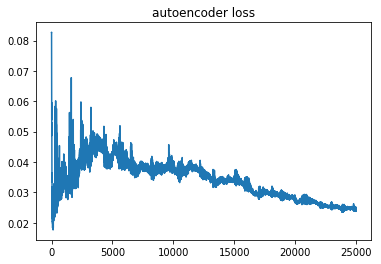

In [7]:
%matplotlib inline

init_epochs = 50
learning_rate = 0.001

losses = []

degrees = dict(network.degree()).values()
sparsity = sum(degrees) / (len(degrees)**2)

if os.path.exists('runs/embeddings'):
    shutil.rmtree('runs/embeddings')
os.makedirs('runs/embeddings/')

avg_deg = sum(dict(network.degree()).values())

model = StaticEncoder(hidden_size = 24, 
                      input_dim = network.number_of_nodes(), 
                      mid_layer=1024, corruption=1/avg_deg).to(device)

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

fig_name = 0
for m in tqdm_notebook(range(500)):
    
    layout = nx.layout.kamada_kawai_layout(network)
    
    for i in range(init_epochs):

        recon_loss = 0.
        total_loss = 0.
        edge_loss = 0.
        iters = 0.
        
        network = nx.read_graphml("runs/graphs/m" + str(5 + 1 * (m)) + ".graphml")
        
        degrees = dict(network.degree()).values()
        sparsity = sum(degrees) / (len(degrees)**2)
        model.corrupt = sparsity
        
        model = wider_input(network.number_of_nodes(), model)
        model = wider_output(network.number_of_nodes(), model)

        adj_list = [(int(n), [int(x) for x in list(neighbors)]) for n, neighbors in network.adjacency()]
        adj_list = dict(adj_list)
        adj_mat = nx.to_numpy_matrix(network)
        adj_mat = torch.tensor(adj_mat)

        data = EdgeData(adj_list, adj_mat)
        loader_train = DataLoader(data,
                            batch_size=8,
                            shuffle=True) 

        model.train()
        for data1, _, data2, _ in loader_train:
    #     for data1, _, county1 in loader_train_encoder:
            optim.zero_grad()
            iters += 1

            train1 = data1.to(device).float()
            train2 = data2.to(device).float()

            preds1, encoded1 = model(train1)
            _, encoded2  = model(train2)

            edge = nn.MSELoss(reduction='mean')(encoded1, encoded2)

            recon = nn.MSELoss(reduction='mean')(preds1, train1)

            l1 = 0.0
            l2 = 0.0
            for p in model.parameters():
                if p.requires_grad:
                    l1 += torch.sum(torch.abs(p))
                    l2 += torch.sum(torch.pow(p, 2))

            l1 *= 0.1
            l1 /= sum(p.numel() for p in model.parameters() if p.requires_grad)
            l2 *=  0.1
            l2 /= sum(p.numel() for p in model.parameters() if p.requires_grad)

            loss = recon + edge + l1 + l2

            if loss.item() != loss.item():
                break

            recon_loss += recon.item()
            edge_loss += edge.item()

            total_loss += loss.item()
            
            loss.backward()
            optim.step()
            
#         embeddings = []
#         for i in range(len(data)):
#             data1, _, _, _ = data[i]
#             train1 = data1.to(device).float()
#             _, encoded1 = model(train1)
#             embeddings.append(encoded1.unsqueeze(1).transpose(0,1))
#         embeddings = torch.cat(embeddings, dim=0)
#         plot_vec = embeddings.to("cpu").detach().numpy()

#         f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
#         attrs = [nx.get_node_attributes(network, 'apt_markakis')[i] for i in network.nodes]
#         ax1.scatter(plot_vec[:,0], plot_vec[:,1], c=attrs)

#         plt.sca(ax1)
#         plt.xticks(np.linspace(-0.1, 0.5, 0.05))
#         plt.yticks(np.linspace(-0.1, 0.5, 0.05))

#         nx.draw(network, node_color=attrs, node_size=20, ax=ax2, pos=layout)

#         plt.savefig('runs/embeddings/' + str(fig_name) + '.png')
#         plt.cla()
#         plt.clf()
#         plt.close('all')
#         fig_name += 1
        
        if (i+1)%20 == 0:
            print("Total Loss: {:.5f} | Recon Loss: {:.5f} | Edge Loss: {:.5f}".format(
                total_loss / iters, recon_loss / iters, edge_loss / iters))
        losses.append(total_loss/iters)
                              

losses = losses[5:]
plt.plot(range(len(losses)), losses)
plt.title("autoencoder loss")
plt.show()

In [8]:
model.eval()

embeddings = []

for i in range(len(data)):

    data1, _, _, _ = data[i]
    train1 = data1.to(device).float()

    _, encoded1 = model(train1)
    embeddings.append(encoded1.unsqueeze(1).transpose(0,1))
    
embeddings = torch.cat(embeddings, dim=0)

embeddings = embeddings.to("cpu").detach().numpy()

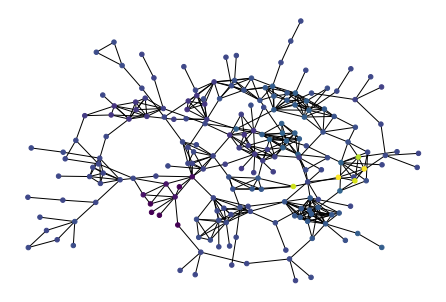

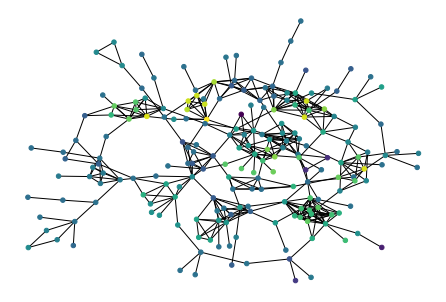

In [9]:
layout = nx.layout.kamada_kawai_layout(network)

clusters = cluster.KMeans().fit_predict(embeddings)

for i in range(2):
    nx.draw(network, pos=layout, node_size=20, node_color=embeddings[:,i])
    plt.show()
    

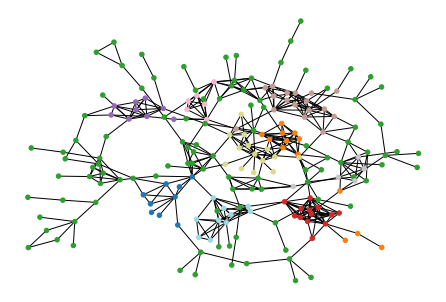

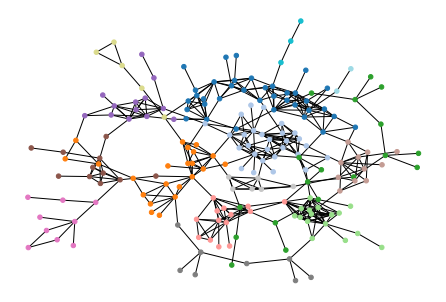

In [10]:
clusters = cluster.KMeans(10, n_init=100).fit_predict(embeddings)
nx.draw(network, pos=layout, node_size=20, node_color=clusters, cmap='tab20')
plt.savefig('kmeans.png')
plt.show()

communities = community.greedy_modularity_communities(network, 10)
community_vec = np.zeros(network.number_of_nodes())
for idx, c in enumerate(communities):
    c = [int(x) for x in c]
    community_vec[c] = idx
    
nx.draw(network, pos=layout, node_size=20, node_color=community_vec, cmap='tab20')
plt.savefig('communities.png')
plt.show()

C:\Users\jxbox\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
C:\Users\jxbox\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


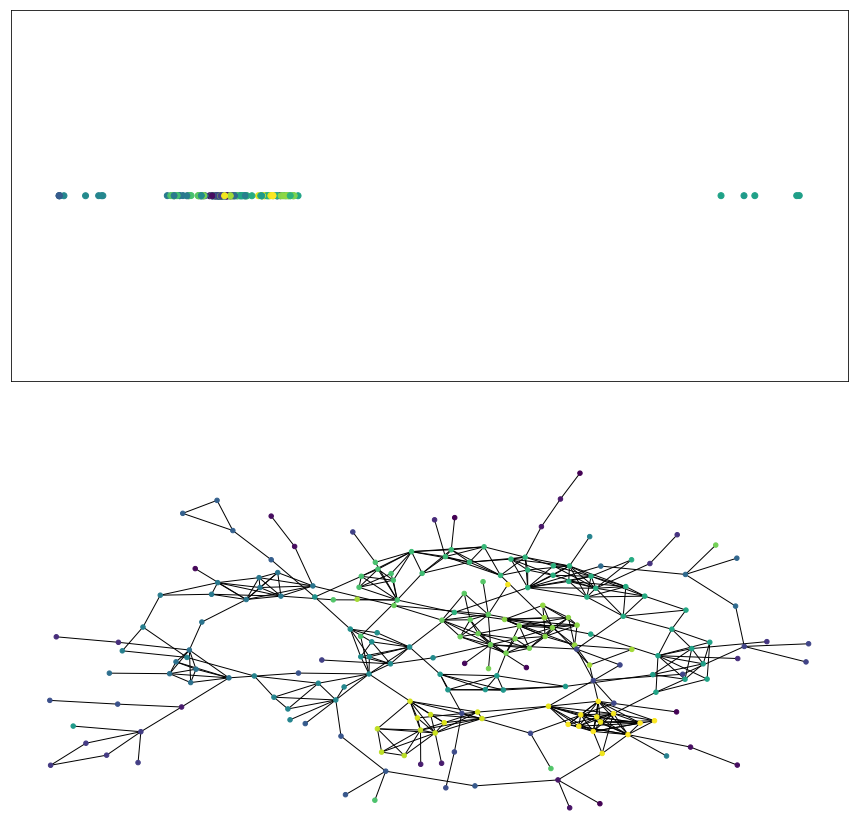

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))

attrs = [nx.get_node_attributes(network, 'apt_markakis')[i] for i in network.nodes]

ax1.scatter(embeddings[:,0], embeddings[:,1], c=attrs)

plt.setp((ax1, ax2), xticks=np.linspace(-0.1, 0.5, 0.05), xticklabels=np.linspace(-0.1, 0.5, 0.05),
        yticks=np.linspace(-0.1, 0.5, 0.05), yticklabels=np.linspace(-0.1, 0.5, 0.05))


# plt.sca(ax1)
# plt.xticks(np.linspace(-0.1, 0.5, 0.05))
# plt.yticks(np.linspace(-0.1, 0.5, 0.05))

nx.draw_kamada_kawai(network, node_color=attrs, node_size=20, ax=ax2)

plt.show()

In [12]:
files = sorted([int(x[:-4]) for x in os.listdir('runs/embeddings/')])
files = [str(x) + '.png' for x in files]

with imageio.get_writer('runs/embedding_gifs/' + str(int(time.time())) + '.gif', mode='I', duration=0.35) as writer:
    for f in files:
        filename = 'runs/embeddings/' + f
        image = imageio.imread(filename)
        writer.append_data(image)
